<a href="https://colab.research.google.com/github/babymlin/Imbalanced/blob/main/retina_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

     |████████████████████████████████| 686kB 35.3MB/s 


In [ ]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224

In [ ]:
# download from google drive or upload file by yourself
# retina.zip url=https://drive.google.com/file/d/1QnG4MGzr7mrDKRq_H0mX8YcLU2NdUxc9/view?usp=sharing
!gdown --id '1QnG4MGzr7mrDKRq_H0mX8YcLU2NdUxc9' --output retina-dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1QnG4MGzr7mrDKRq_H0mX8YcLU2NdUxc9
To: /content/retina-dataset.zip
35.1MB [00:01, 32.9MB/s]


In [ ]:
# unzip dataset file
!unzip -q retina-dataset.zip

#### Data Visualization

In [ ]:
paths = glob('retina-train/*.jpeg')
paths_test = sorted(glob('retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

retina-train/5258_right_2.jpeg


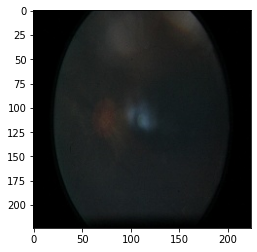

In [ ]:
#idx = np.random.randint(0, len(paths), size=1)[0]
#path = paths[idx]
path = 'retina-train/5258_right_2.jpeg'
img = cv2.imread(path)# [:,:,::-1]
plt.imshow(img[:,:,::-1])
print(path)

(224, 224, 3)


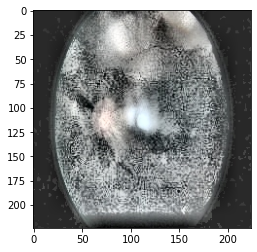

In [ ]:
#CLAHE
img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(img_y_cr_cb)

# Applying CLAHE operation on Y channel.
clahe = cv2.createCLAHE()
y_eq = clahe.apply(y)
img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)
plt.imshow(img_rgb_eq)
print(img_rgb_eq.shape)

(224, 224, 3)


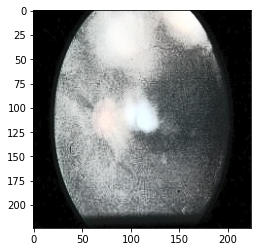

In [ ]:
# Histogram Equalization
img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(img_y_cr_cb)

# Applying equalize Hist operation on Y channel.
y_eq = cv2.equalizeHist(y)
img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)
plt.imshow(img_rgb_eq)
print(img_rgb_eq.shape)

In [ ]:
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])

all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~4
print(all_cls[:3])

['44123_left_0.jpeg', '5758_right_1.jpeg', '27812_right_0.jpeg']
[0, 1, 0]


<BarContainer object of 3 artists>

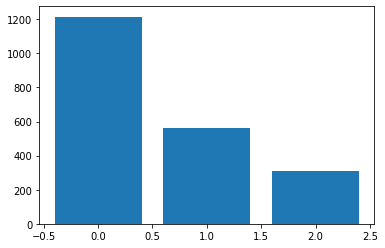

In [ ]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Build Transfer Learning Model

In [ ]:
# Method 1: 
# clear graph
tf.keras.backend.clear_session()

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(3)(x)
predictions = layers.Softmax()(x)

# Freeeze layers
for l in base_model.layers:
    l.trainable = False

model = models.Model(base_model.input, predictions)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
#model.summary()

#### Prepare Data

In [ ]:
# split dataset
path_train, path_val = train_test_split(paths, test_size=0.2)

len(path_train), len(path_val)

(1668, 418)

In [ ]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))

    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (img_size, img_size))
        # preprocess by histogram equlization
        img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(img_y_cr_cb)
        # Applying equalize Hist operation on Y channel.
        #clahe = cv2.createCLAHE()
        #y_eq = clahe.apply(y)
        y_eq = cv2.equalizeHist(y)
        img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
        img = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)

        # !!!!!!!!! Use model preprocessing function !!!!!!!!!!
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        #y_data = utils.to_categorical(y_data, num_classes=num_classes) # one-hot encoding
        return x_data, y_data
    else:
        return x_data

In [ ]:
x_train, y_train = create_dataset(path_train)
x_val, y_val = create_dataset(path_val)
x_test = create_dataset(paths_test, test=True)

100%|██████████| 522/522 [00:00<00:00, 618.26it/s]


In [ ]:
train_datagen = ImageDataGenerator(
                    rotation_range=0,
                    horizontal_flip=True,
                    vertical_flip=False,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    preprocessing_function=preprocess_input
                    )
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

<BarContainer object of 3 artists>

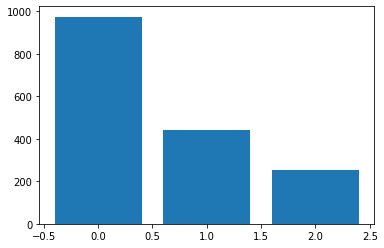

In [ ]:
# y_train Class distribution
cls, count = np.unique(y_train, return_counts=True)
plt.bar(cls, count)

In [ ]:
# y_train class_weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',
                    cls,
                    y_train)
class_weights = {i:value for i, value in enumerate(class_weights)}
print(class_weights)

{0: 0.5708418891170431, 1: 1.257918552036199, 2: 2.2063492063492065}


In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 224, 224, 3), (1668,), (418, 224, 224, 3), (418,))

#### Training

In [ ]:
import os
model_dir = "retina"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
file_name = "retina-best-model"
modelfile = f"{model_dir}/{file_name}.h5"
logfile = f"{model_dir}/{file_name}_training.log"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
model_chpo = tf.keras.callbacks.ModelCheckpoint(modelfile, monitor='val_categorical_accuracy', save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
csv_logger = tf.keras.callbacks.CSVLogger(logfile)
callbacks_list = [model_chpo, earlystop, csv_logger]

In [ ]:
radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
model.compile(optimizer=ranger, 
        loss=losses.sparse_categorical_crossentropy, 
        metrics=[metrics.categorical_accuracy])

In [ ]:
logs = model.fit(x_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(x_val, y_val),
          verbose=2,
          class_weight=class_weights,
          callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
53/53 - 42s - loss: 1.0959 - categorical_accuracy: 0.2140 - val_loss: 1.0457 - val_categorical_accuracy: 0.5694


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
53/53 - 5s - loss: 1.0276 - categorical_accuracy: 0.4814 - val_loss: 0.9653 - val_categorical_accuracy: 0.4378
Epoch 3/50
53/53 - 5s - loss: 0.9209 - categorical_accuracy: 0.5450 - val_loss: 0.8852 - val_categorical_accuracy: 0.5096
Epoch 4/50
53/53 - 5s - loss: 0.8681 - categorical_accuracy: 0.4664 - val_loss: 0.8512 - val_categorical_accuracy: 0.5478
Epoch 5/50
53/53 - 4s - loss: 0.8381 - categorical_accuracy: 0.5138 - val_loss: 0.8561 - val_categorical_accuracy: 0.3445
Epoch 6/50
53/53 - 4s - loss: 0.8001 - categorical_accuracy: 0.4412 - val_loss: 0.8243 - val_categorical_accuracy: 0.4904
Epoch 7/50
53/53 - 4s - loss: 0.7855 - categorical_accuracy: 0.4496 - val_loss: 0.7560 - val_categorical_accuracy: 0.7871
Epoch 8/50
53/53 - 4s - loss: 0.7779 - categorical_accuracy: 0.4958 - val_loss: 0.7587 - val_categorical_accuracy: 0.6842
Epoch 9/50
53/53 - 4s - loss: 0.7495 - categorical_accuracy: 0.4976 - val_loss: 0.8494 - val_categorical_accuracy: 0.3230
Epoch 10/50
53/53 - 4s -

In [ ]:
model_dir = 'retina'
file_name = "retina-best-model"
modelfile = f"{model_dir}/{file_name}.h5"
model = tf.keras.models.load_model(modelfile)

In [ ]:
model.evaluate(x_val, y_val)

14/14 [==============================] - 2s 65ms/step - loss: 0.7560 - categorical_accuracy: 0.7871


[0.75604248046875, 0.7870813608169556]

#### Make Submission file

Kaggle: https://www.kaggle.com/c/retinopathy-classification-sai/data


In [ ]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,10017_left.jpeg,2
1,10031_right.jpeg,0
2,10150_left.jpeg,0
3,10154_right.jpeg,0
4,10440_right.jpeg,0
...,...,...
517,9608_left.jpeg,2
518,9673_right.jpeg,0
519,9690_left.jpeg,2
520,9717_right.jpeg,0
